In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import hashlib 
from collections import defaultdict

# Множественное тестирование
#### FWER - групповая вероятность ошибки первого рода
Посмотрим как меняется FWER при увеличении кол-ва экспериментов
$$FWER = \mathbb{P}(V > 0)$$
$V$ - число ложно положительных результатов

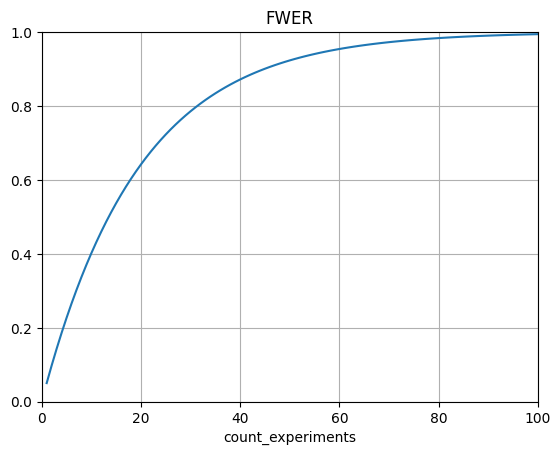

In [2]:
alpha = 0.05
n_exps = np.arange(1, 101)
array_fwer = 1 - (1 - alpha) ** n_exps

plt.plot(n_exps, array_fwer, '-')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 100])
plt.xlabel('count_experiments')
plt.title('FWER')
plt.show()

## 1. Поправки на множественное тестирование
### 1.1 Без поправок

Сгенерим pvalue из равномерного распределения на [0, 1], предполагая, что верна нулевая гипотеза о равенстве средних.

In [3]:
def method_without_correct(pvalues, alpha=0.05):
    """Проверяет значимость отличий без поправок.

    :param pvalues (np.array): массив pvalue
    :param alpha (float): уровень значимости

    :return res (np.array): массив из нулей и единиц:
        0 - значимых отличий нет, 1 - значимые отличия есть.
    """
    res = (pvalues <= alpha).astype(int)
    return res


n_exp = 50
array_pvalues = np.random.rand(10000, n_exp)
has_error = [sum(method_without_correct(row)) > 0 for row in array_pvalues]
print(f'FWER без поправок: {np.mean(has_error):0.3f}')

FWER без поправок: 0.921


### 1.2 Метод Бонферрони

In [4]:
def method_bonferroni(pvalues, alpha=0.05):
    """Применяет метод Бонферрони для проверки значимости изменений.

    :param pvalues (np.array): массив pvalue
    :param alpha (float): уровень значимости

    :return res (np.array): массив из нулей и единиц:
        0 - значимых отличий нет, 1 - значимые отличия есть.
    """
    m = len(pvalues)
    res = (pvalues <= alpha / m).astype(int)
    return res

array_pvalues = np.random.rand(10000, n_exp)
has_error = [sum(method_bonferroni(row)) > 0 for row in array_pvalues]
print(f'FWER с поправкой Бонферрони: {np.mean(has_error):0.3f}')

FWER с поправкой Бонферрони: 0.050


Есть функция для работы с множественным тестированием.

In [6]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [7]:
multipletests(array_pvalues[18], alpha=alpha, method='bonferroni')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 0.001025339867231967,
 0.001)

Функция выдаёт скорректированные $pvalue^* = min([1, pvalue \times size])$, что эквивалентно сравнению исходного pvalue с порогом $\dfrac{\alpha}{size}$.

### 1.3. Метод Холма

In [8]:
def method_holm(pvalues, alpha=0.05):
    """Применяет метод Холма для проверки значимости изменений.
    
    :param pvalues (np.array): массив pvalue
    :param alpha (float): уровень значимости

    :return res (np.array): массив из нулей и единиц:
        0 - значимых отличий нет, 1 - значимые отличия есть.
    """
    m = len(pvalues)
    alphas = alpha / np.arange(m, 0, -1)
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m, dtype=int)
    for alpha_, pvalue_index in zip(alphas, sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        if pvalue < alpha_:
            res[pvalue_index] = 1
        else:
            break
    return res

array_pvalues = np.random.rand(100, n_exp)
has_error = [np.sum(method_holm(row)) > 0 for row in array_pvalues]
print(f'FWER с поправкой Холма: {np.mean(has_error):0.3f}')

FWER с поправкой Холма: 0.070


Сравним с функцией из statmodels (**ДОЛГО СЧИТАЕТ**)

In [9]:
has_error = [
    int(True in multipletests(row, alpha=alpha, method='holm')[0])
    for row in tqdm(array_pvalues)
]
print(f'FWER с поправкой Холма: {np.mean(has_error):0.3f}')

  0%|          | 0/100 [00:00<?, ?it/s]

FWER с поправкой Холма: 0.070


### 1.4. Метод Бенджамини-Хохберга

In [10]:
def method_benjamini_hochberg(pvalues, alpha=0.05):
    """Применяет метод Бенджамини-Хохберга для проверки значимости изменений.
    
    :param pvalues (np.array): массив pvalue
    :param alpha (float): уровень значимости

    :return res (np.array): массив из нулей и единиц:
        0 - значимых отличий нет, 1 - значимые отличия есть.
    """
    m = len(pvalues)
    alphas = alpha * np.arange(1, m+1) / m
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m, dtype=int)
    for alpha_, pvalue_index in zip(alphas, sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        if pvalue <= alpha_:
            res[pvalue_index] = 1
        else:
            break
    return res

array_pvalues = np.random.rand(10000, n_exp)
has_error = [np.sum(method_benjamini_hochberg(row)) > 0 for row in array_pvalues]
print(f'FWER с поправкой Бенджамини-Хохберга: {np.mean(has_error):0.3f}')

FWER с поправкой Бенджамини-Хохберга: 0.049


Когда все эксперименты без эффекта, ошибки первого рода практически совпадают на этих данных.

### 1.5. Сравнение методов.
Посмотрим как меняется кол-во ошибок первого и второго рода при изменении кол-ва пилотов с эффектом.

  0%|          | 0/1000 [00:00<?, ?it/s]

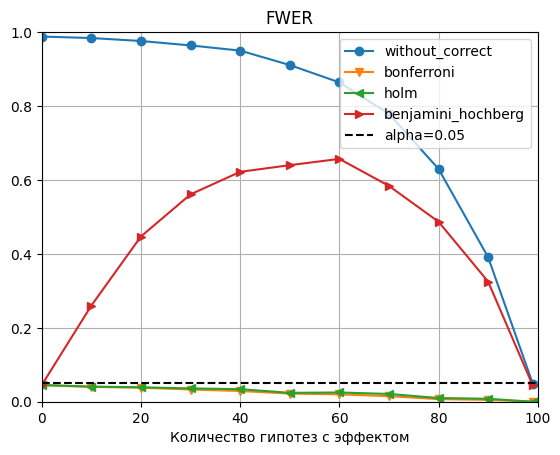

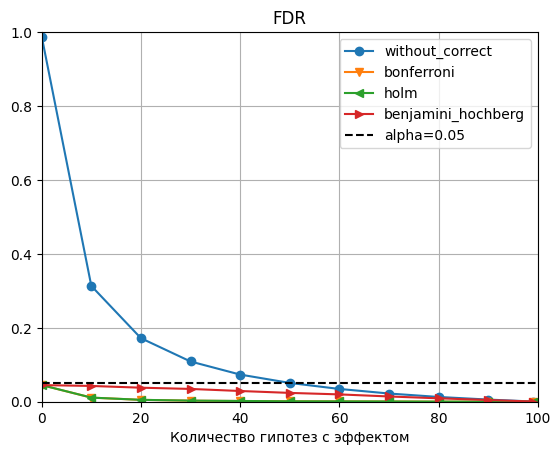

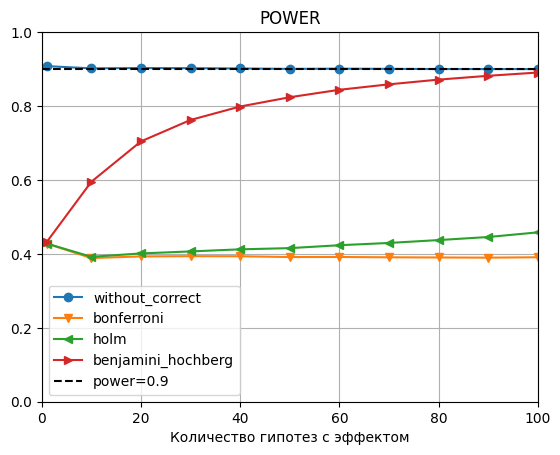

In [11]:
def estimate_sample_size(effect, std, alpha, beta):
    """Оценка необходимого размер групп."""
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int(np.ceil((t_alpha + t_beta) ** 2 * var / (effect ** 2)))
    return sample_size


def run(dict_methods, mean, std, sample_size, n_exp, n_iter=1000):
    """Проводит симуляцию экспериментов.
    
    :param dict_methods: словарь с методами множественного тестирования
    :param mean: среднее значение генерируемых данных
    :param std: стандартное отклонение генерируемых данных
    :param sample_size: размер групп
    :param n_exp: количество проверяемых гипотез
    :param n_iter: количество итераций симуляции

    :return method_2_result: результаты применения методов к данным симуляции
    """
    list_n_exp_with_effect = [0, 1] + list(range(10, n_exp, 10)) + [n_exp-1, n_exp]
    method_2_result = {
        method_name: defaultdict(list)
        for method_name in dict_methods
    }
    for _ in tqdm(range(n_iter)):
        a_values, b_values = np.random.normal(mean, std, (2, n_exp, sample_size))
        prev_n_exp_with_effect = 0
        for n_exp_with_effect in list_n_exp_with_effect:
            b_values[prev_n_exp_with_effect: n_exp_with_effect] += effect
            prev_n_exp_with_effect = n_exp_with_effect
            pvalues = stats.ttest_ind(a_values, b_values, axis=1).pvalue
            for method_name, method in dict_methods.items():
                res = method(pvalues)
                method_2_result[method_name][n_exp_with_effect].append({
                    'FN': sum(res[:n_exp_with_effect] == 0),
                    'TP': sum(res[:n_exp_with_effect] == 1),
                    'FP': sum(res[n_exp_with_effect:] == 1),
                    'TN': sum(res[n_exp_with_effect:] == 0),
                })
    return method_2_result


def plot_metrics(method_2_result, n_exp, alpha=0.05, beta=0.1):
    """Рисует графики."""
    method_2_metrics = {method_name: defaultdict(list) for method_name in method_2_result}
    markers = ['o', 'v', '<', '>', '^', 's']
    for method_name in method_2_result:
        list_n_exp_with_effect = sorted(method_2_result[method_name].keys())
        for n_exp_with_effect in list_n_exp_with_effect:
            results = method_2_result[method_name][n_exp_with_effect]
            fwer = np.mean([x['FP'] > 0 for x in results])
            fdr = np.mean([x['FP'] / max(1, x['FP'] + x['TP']) for x in results])
            power = np.mean([x['TP'] / max(1, x['FN'] + x['TP']) for x in results])
            method_2_metrics[method_name]['FWER'].append(fwer)
            method_2_metrics[method_name]['FDR'].append(fdr)
            method_2_metrics[method_name]['POWER'].append(power)
    for metric_name in ['FWER', 'FDR', 'POWER']:
        min_value = 1
        for idx, (method_name, metrics) in enumerate(method_2_metrics.items()):
            marker = markers[idx % len(markers)]
            if metric_name in ['FWER', 'FDR']:
                X = list_n_exp_with_effect[:1] + list_n_exp_with_effect[2: -1]
                Y = metrics[metric_name][:1] + metrics[metric_name][2: -1]
            elif metric_name == 'POWER':
                X = list_n_exp_with_effect[1: -2] + list_n_exp_with_effect[-1:]
                Y = metrics[metric_name][1: -2] + metrics[metric_name][-1:]
            min_value = min(min_value, min(Y))
            plt.plot(X, Y, f'-{marker}', label=method_name)
        if metric_name in ['FWER', 'FDR']:
            plt.hlines(alpha, 0, n_exp, 'k', linestyles='--', label=f'alpha={alpha}')
        else:
            plt.hlines(1-beta, 0, n_exp, 'k', linestyles='--', label=f'power={1-beta}')
        plt.title(metric_name)
        plt.xlabel('Количество гипотез с эффектом')
        plt.legend()
        plt.grid()
        plt.xlim([0, n_exp])
        plt.ylim([0.8 if min_value > 0.8 else 0, 1])
        plt.show()

alpha = 0.05              # уровень значимости
beta = 0.1                # допустимая вероятность ошибки II рода
mean = 1000               # средняя выручка с пользователя в контрольной группе
std = 600                 # стандартное отклонение
effect = 276              # ожидаемый размер эффекта
sample_size = estimate_sample_size(effect, std, alpha, beta)
n_exp = 100               # количество проверяемых гипотез
dict_methods = {
    'without_correct': method_without_correct,
    'bonferroni': method_bonferroni,
    'holm': method_holm,
    'benjamini_hochberg': method_benjamini_hochberg,
}
method_2_result = run(dict_methods, mean, std, sample_size, n_exp)
plot_metrics(method_2_result, n_exp)

Чтобы контролировать мощность на заданном уровне, попробуем использовать уровень значимости, равный $\alpha / m$ в формуле для оценки необходимого размера групп.

  0%|          | 0/1000 [00:00<?, ?it/s]

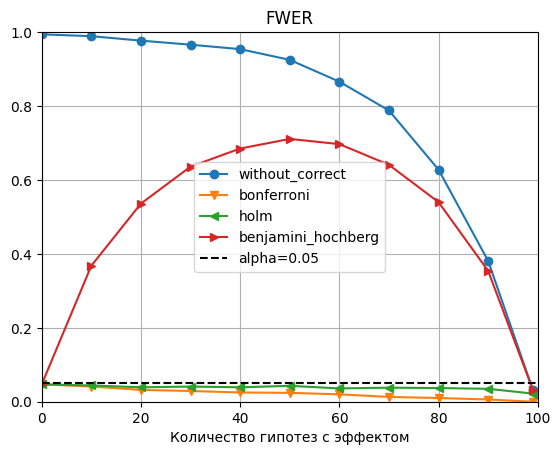

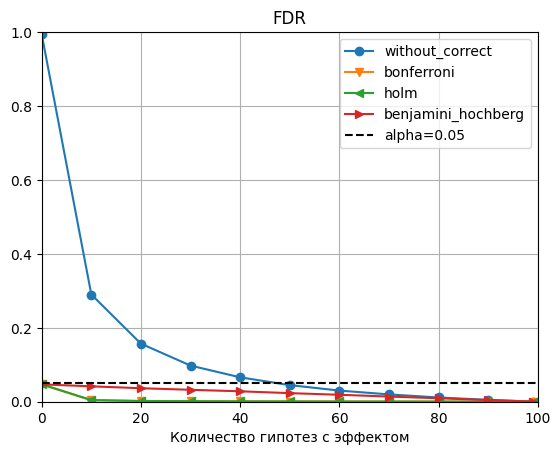

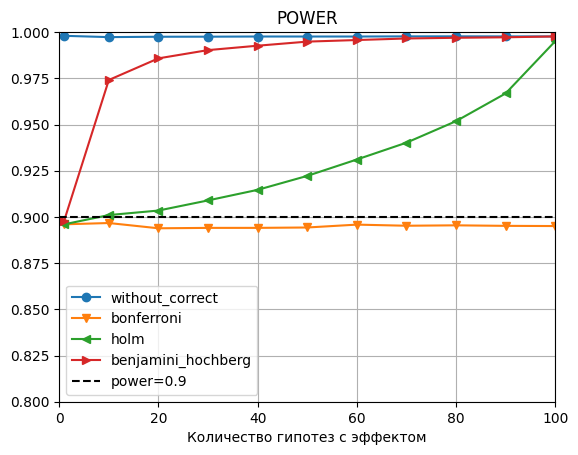

In [12]:
sample_size = estimate_sample_size(effect, std, alpha / n_exp, beta)
method_2_result = run(dict_methods, mean, std, sample_size, n_exp)
plot_metrics(method_2_result, n_exp)

Мощность метода Бонферрони чуть меньше 0.9. Это связано с тем, что при оценке необходимого размера групп используется приближение нормальным распределением вместо распределения Стьюдента. 

## 2. Общий контроль

При проверке 100 гипотез у каждой гипотезы были свои контрольные группы. Контрольные группы можно объединить в единую контрольную группу и использовать её для проверки всех гипотез. С одной стороны, значения p-value станут зависимыми. С другой стороны, увеличение размера контрольной группы приведёт к увеличению чувствительности.

Какой выбрать размер групп, чтобы мощность сохранилась на желаемом уровне? Вспомним формулу, связывающую параметры критерия:

$$
\varepsilon^2 = \left[ \Phi^{-1} \left( 1- \alpha / 2 \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 \left(\frac{\sigma_A^2}{n_A} + \frac{\sigma_B^2}{n_B}\right)
$$

Проверяем m гипотез c объединённой контрольной группой. Положим $n_A=n m$, $n_B=n$ и $\sigma=\sigma_A=\sigma_B$, тогда

$$
n = \frac{m+1}{m} \frac{\sigma^2}{\varepsilon^2} \left[ \Phi^{-1} \left( 1- \alpha / 2 \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2
$$

При m=1 получаем (m+1)/m=2, а при m=100 получаем (m+1)/m=1.01. Ранее размер групп был равен 215, теперь будем использовать размер групп, равный $215/2*1.01 \approx 109$. Проведём численный эксперимент:

  0%|          | 0/1000 [00:00<?, ?it/s]

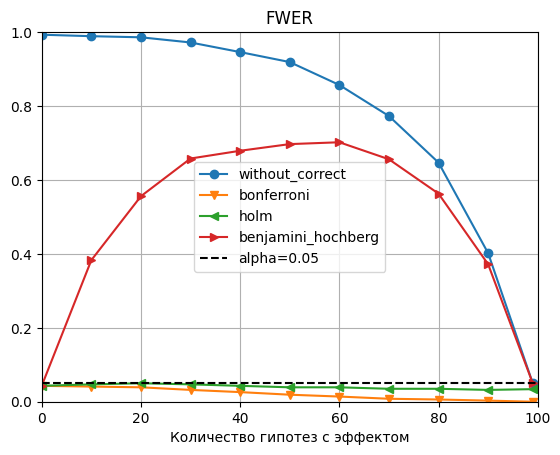

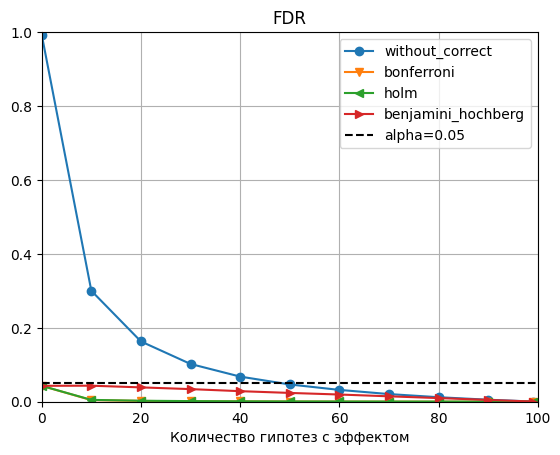

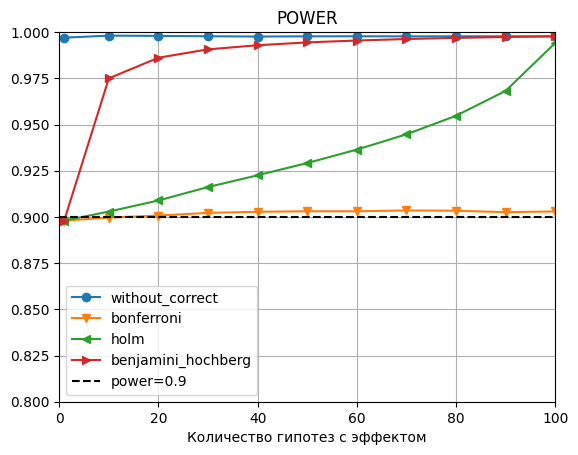

In [13]:
sample_size = 109
list_n_exp_with_effect = [0, 1] + list(range(10, n_exp, 10)) + [n_exp-1, n_exp]
method_2_result = {
    method_name: defaultdict(list)
    for method_name in dict_methods
}
for _ in tqdm(range(1000)):
    a_values, b_values = np.random.normal(mean, std, (2, n_exp, sample_size))
    a_values = [a_values.flatten()]
    prev_n_exp_with_effect = 0
    for n_exp_with_effect in list_n_exp_with_effect:
        b_values[prev_n_exp_with_effect: n_exp_with_effect] += effect
        prev_n_exp_with_effect = n_exp_with_effect
        pvalues = stats.ttest_ind(a_values, b_values, axis=1).pvalue
        for method_name, method in dict_methods.items():
            res = method(pvalues)
            method_2_result[method_name][n_exp_with_effect].append({
                'FN': sum(res[:n_exp_with_effect] == 0),
                'TP': sum(res[:n_exp_with_effect] == 1),
                'FP': sum(res[n_exp_with_effect:] == 1),
                'TN': sum(res[n_exp_with_effect:] == 0),
            })
plot_metrics(method_2_result, n_exp)

Качество работы методов не изменилось, а необходимый объём данных уменьшился почти в 2 раза. На самом деле, можно получить ещё больший выигрыш при оптимальном разбиении пользователей на группы. Для этого нужно найти оптимум для системы:


$$
\left\{
\begin{aligned}
    & \dfrac{1}{n_A} +\dfrac{1}{n_B} \to \min_{n_A, n_B} \\
    & n_A + m * n_B = N
\end{aligned}
\right.
$$

## 3. Пример - Эксперимент с дизайном

Провели эксперимент, в котором меняли цвет текста на сайте.

Проверяется гипотеза о равенстве средних.

Данные в файле `07-design_df.csv`, который содержит столбцы:
- `user_id` - id пользователя
- `value` - значение метрики сумма покупок
- `exp1` - разбиение на группы в одном эксперименте: 0 - контрольная, 1 - экспериментальная
- `exp2` - разбиение на группы в другом эксперименте: 0 - контрольная, 1 - экспериментальная

Нужно оценить эксперимент.

In [14]:
df = pd.read_csv('07-design_df.csv')
a, b = [df[df['exp1'] == group]['value'].values for group in [0, 1]]
delta = b.mean() - a.mean()
pvalue = stats.ttest_ind(a, b).pvalue
print(f'delta = {delta:0.3f}, pvalue = {pvalue:0.3f}')

delta = -118.503, pvalue = 0.008


Пришли со вторым экспериментом, оцените его

In [15]:
a, b = [df[df['exp2'] == group]['value'].values for group in [0, 1]]
delta = b.mean() - a.mean()
pvalue = stats.ttest_ind(a, b).pvalue
print(f'delta = {delta:0.3f}, pvalue = {pvalue:0.3f}')

delta = -133.862, pvalue = 0.003


Почему оба эксперимента оказались провальными?

In [16]:
df.groupby(['exp1', 'exp2'])['value'].mean().astype(int).reset_index()

,exp1,exp2,value
0,0,0,2381
1,0,1,2493
2,1,0,2522
3,1,1,2137


### Несовместные эксперименты

Несовместные эксперименты — эксперименты, которые нельзя проводить одновременно на одних и тех же пользователях. Если пользователь попадает в пилотные групп двух несовместных экспериментов, то эффект, скорее всего, будет негативным.

![image info](multi_colors.png)

Можно сказать, что у нас прошло сразу три эксперимента, с одной контрольной группой (exp1=0 и exp2=0) и тремя экспериментальными ([0, 1], [1, 0] и [1, 1] для exp1 и exp2 соответственно).

Проверим значимость отличий трёх экспериментов

In [17]:
v_00 = df[(df['exp1'] == 0) & (df['exp2'] == 0)]['value'].values
v_10 = df[(df['exp1'] == 1) & (df['exp2'] == 0)]['value'].values
v_01 = df[(df['exp1'] == 0) & (df['exp2'] == 1)]['value'].values
v_11 = df[(df['exp1'] == 1) & (df['exp2'] == 1)]['value'].values

pvalue_10 = stats.ttest_ind(v_00, v_10).pvalue
pvalue_01 = stats.ttest_ind(v_00, v_01).pvalue
pvalue_11 = stats.ttest_ind(v_00, v_11).pvalue

print(pvalue_01, pvalue_10, pvalue_11)

0.0647390540662083 0.023229802439958737 0.00021192148082988698


## 4. Двойное хэширование

Для распределения пользователей по экспериментам используют технику двойного хэширования:

1. Для каждого слоя распределяем пользователей по N бакетам;
2. Распределяем эксперименты по бакетам;
3. Для каждой пары эксперимент-пользователь определяем группу (контрольная/экспериментальная).

Распределение по экспериментам

![image info](multi_split_1.png)

Распределение по группам

![image info](multi_split_2.png)


### Разбиение с помощью хэш-функции

**Хеш-функция** — функция, осуществляющая преобразование любой строки в соответствующую ей выходную битовую строку установленной длины, которую можно интерпретировать как число. Хорошая хеш-функция обеспечивает равномерное и близкое к случайному распределение результатов по всей области допустимых значений. Это позволяет использовать хэш для случайного перемешивания данных.

In [18]:
def get_hash_modulo(value: str, modulo: int, salt: str):
    """Вычисляем остаток от деления: hash(value + salt) % modulo."""
    hash_value = int(hashlib.md5(str.encode(value + salt)).hexdigest(), 16)
    return hash_value % modulo

get_hash_modulo('user_id_1234', 1000, 'abcf')

850

In [19]:
for i in range(10):
    hash_ = get_hash_modulo(f"{i}", 5, 'a')
    print(f'i={i}  hash={hash_}')

i=0  hash=1
i=1  hash=3
i=2  hash=3
i=3  hash=0
i=4  hash=1
i=5  hash=2
i=6  hash=0
i=7  hash=0
i=8  hash=3
i=9  hash=4


Проверим равномерность распределения

example user_ids:
['-1.0696793605568193' '0.15134611003626416' '-0.37233456657373637']
example hash_values:
[85, 62, 1]


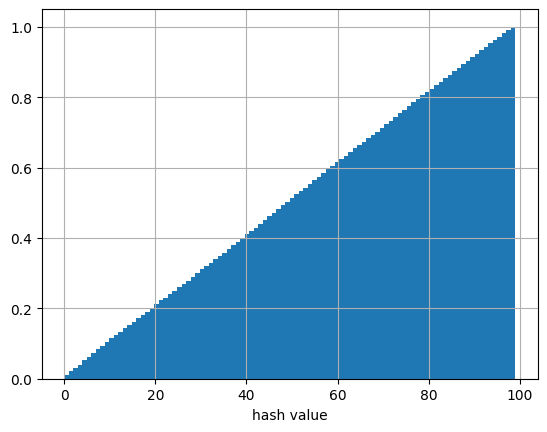

In [20]:
user_ids = np.random.normal(0, 1, 10000).astype(str)
print(f'example user_ids:\n{user_ids[:3]}')

hash_values = [get_hash_modulo(user_id, 100, 'sa') for user_id in user_ids]
print(f'example hash_values:\n{hash_values[:3]}')

plt.hist(hash_values, bins=100, cumulative=True, density=True)
plt.grid()
plt.xlabel('hash value')
plt.show()

## 5. Доля успешных экспериментов

Научились проводить много экспериментов.
</br>Провели много экспериментов.
</br>Проанализируем что получилось.

#### Задание

Было проведено 1000 независимых экспериментов.
</br>Проверялись двусторонние гипотезы о равенстве средних.
</br>В 81 из них были получены статистически значимые позитивные отличия, они были внедрены.
</br>При дизайне экспериментов вероятности ошибок I и II рода были равны 0.05 и 0.1 соответственно.
</br>Оцените количество внедрённых изменений, у которых эффект на самом деле был.
